### Notebook for the label transfer of Healthy Human Heart fibroblasts to mouse heart using `scANVI`

- **Developed by:** Carlos Talavera-López Ph.D
- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**
- v240311

### Import required modules

In [1]:
import scvi
import torch
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as p
from pywaffle import Waffle
import matplotlib.pyplot as plt
from scib_metrics.benchmark import Benchmarker

### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.5.post1
scanpy      1.9.8
-----
PIL                 10.2.0
absl                NA
asttokens           NA
attr                23.2.0
chex                0.1.85
comm                0.2.1
contextlib2         NA
cycler              0.12.1
cython_runtime      NA
dateutil            2.8.2
debugpy             1.8.1
decorator           5.1.1
docrep              0.3.2
etils               1.7.0
executing           2.0.1
flax                0.8.1
fsspec              2024.2.0
h5py                3.10.0
igraph              0.11.4
importlib_resources NA
ipykernel           6.29.2
ipywidgets          8.1.2
jax                 0.4.19
jaxlib              0.4.19
jedi                0.19.1
joblib              1.3.2
kiwisolver          1.4.5
lightning           2.1.4
lightning_utilities 0.10.1
llvmlite            0.42.0
matplotlib          3.8.3
mizani              0.11.0
ml_collections      NA
ml_dtypes           0.3.2
mpl_toolkits        NA
msgpack             1.0.7
mudata        

In [3]:
torch.set_float32_matmul_precision('high')

In [4]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'

Seed set to 1712


In [5]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 2,
)

### Read in Healthy data

In [6]:
reference = sc.read_h5ad('../../../data/hca_heart_global_ctl230918_states_formatted.h5ad')
reference

AnnData object with n_obs × n_vars = 452506 × 22260
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels'
    var: 'gene_ids-Harvard-Nuclei-full', 'feature_types-Harvard-Nuclei-full', 'gene_ids-Sanger-Nuclei-full', 'feature_types-Sanger-Nuclei-full', 'gene_ids-Sanger-Cells-full', 'feature_types-Sanger-Cells-full', 'gene_ids-Sanger-CD45-full', 'feature_types-Sanger-CD45-full', 'n_cells-myeloid', 'n_counts-myeloid'

In [7]:
reference.obs['cell_states'].cat.categories

Index(['Adip1', 'Adip2', 'Adip3', 'Adip4', 'B', 'B_plasma', 'CD14+Mo',
       'CD4+T_Tfh', 'CD4+T_Th1', 'CD4+T_Th17', 'CD4+T_Th2', 'CD4+T_act',
       'CD4+T_naive', 'CD4+T_reg', 'CD69+Mo', 'CD8+T_cytox', 'CD8+T_em',
       'CD8+T_te', 'CD8+T_trans', 'Cycling_T/NK', 'DC2', 'DOCK4+aMØ',
       'DOCK4+vMØ', 'EC10_CMC-like', 'EC1_cap', 'EC2_cap', 'EC3_cap',
       'EC4_immune', 'EC5_art', 'EC6_ven', 'EC7_atria', 'EC8_ln',
       'EC9_FB-like', 'FB1', 'FB2', 'FB3', 'FB4', 'FB5', 'FB6', 'ILC',
       'LYVE1+MØ1', 'LYVE1+MØ2', 'M2MØ', 'MAIT-like', 'Mast', 'Meso', 'MoMø',
       'NC1', 'NC2', 'NC3', 'NC4', 'NC5', 'NC6', 'NK_CD16hi', 'NK_CD56hi',
       'NØ', 'PC1_vent', 'PC2_atria', 'PC3_str', 'PC4_CMC-like', 'SMC1_basic',
       'SMC2_art', 'TREM2+MØ', 'aCM1', 'aCM2', 'aCM3', 'aCM4', 'aCM5', 'gdT',
       'nøMo', 'pDC', 'proIMØ', 'unclassfied.1', 'unclassfied.2', 'vCM1',
       'vCM2', 'vCM3', 'vCM4', 'vCM5'],
      dtype='object')

### Subset population of interest

In [8]:
reference = reference[reference.obs['cell_states'].isin(['FB1', 'FB2', 'FB3', 'FB4', 'FB5', 'FB6'])]
reference.obs['cell_states'].cat.categories

Index(['FB1', 'FB2', 'FB3', 'FB4', 'FB5', 'FB6'], dtype='object')

- Remove annotations with less than 10 cells

In [9]:
reference.obs['seed_labels'] = reference.obs['cell_states'].copy()
reference.obs['seed_labels'].value_counts()

seed_labels
FB1    26632
FB2    13779
FB3     7744
FB4     6146
FB5     2518
FB6     1610
Name: count, dtype: int64

In [10]:
reference.obs['seed_labels'].cat.categories

Index(['FB1', 'FB2', 'FB3', 'FB4', 'FB5', 'FB6'], dtype='object')

### Subset populations of interest

In [11]:
reference = reference[~reference.obs['seed_labels'].isin(['nan'])]
reference.obs['seed_labels'].value_counts()

seed_labels
FB1    26632
FB2    13779
FB3     7744
FB4     6146
FB5     2518
FB6     1610
Name: count, dtype: int64

In [12]:
sc.pp.filter_cells(reference, min_genes = 200)
sc.pp.filter_cells(reference, min_counts = 100)

In [13]:
reference.obs['cell_source'].value_counts()

cell_source
Sanger-Nuclei     40521
Harvard-Nuclei    15054
Sanger-Cells       2227
Sanger-CD45         627
Name: count, dtype: int64

### Read in other query

In [14]:
Kdm6aKO_ALL = sc.read_h5ad('../../../data/Kdm6aKO_ALL_GEX-CB_scANVI-CellStates_ctl240116.raw.h5ad')
Kdm6aKO_ALL.obs['C_scANVI'].cat.categories

Index(['Adip1', 'DOCK4+vMØ', 'EC1_cap', 'EC3_cap', 'EC5_art', 'EC6_ven', 'FB1',
       'Mast', 'NC1', 'NK_CD16hi', 'PC1_vent', 'SMC1_basic', 'nøMo', 'vCM1',
       'vCM3'],
      dtype='object')

In [15]:
query = Kdm6aKO_ALL[Kdm6aKO_ALL.obs['C_scANVI'].isin(['FB1'])]
query

View of AnnData object with n_obs × n_vars = 8768 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'group', 'file', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'genome', 'modality', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [17]:
query.obs['cell_source'] = 'Becker-Nuclei'
query.obs['seed_labels'] = 'Unknown'
query.obs['donor'] = query.obs['sample'].copy()
query

AnnData object with n_obs × n_vars = 8768 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'group', 'file', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'genome', 'modality', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [18]:
sc.pp.filter_cells(query, min_genes = 200)
sc.pp.filter_cells(query, min_counts = 100)

### Change gene symbols for label transfer

In [19]:
query.var_names = [gene_name.upper() for gene_name in query.var_names]
query.var_names

Index(['XKR4', 'GM1992', 'GM19938', 'GM37381', 'RP1', 'SOX17', 'GM37587',
       'GM37323', 'MRPL15', 'LYPLA1',
       ...
       'GM16367', 'AC163611.1', 'AC163611.2', 'AC140365.1', 'AC124606.2',
       'AC124606.1', 'AC133095.2', 'AC133095.1', 'AC234645.1', 'AC149090.1'],
      dtype='object', length=32285)

In [20]:
adata = reference.concatenate(query, batch_key = 'batch', batch_categories = ['reference', 'query'], join = 'inner')
adata

AnnData object with n_obs × n_vars = 67197 × 14249
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'group', 'file', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-query', 'feature_types-query', 'genome-query', 'modality-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'gene_ids-Harvard-Nuclei-full-reference', 'feature_types-Harvard-Nuclei-full-reference', 'gene_ids-Sanger-Nuclei-full-reference', 'feature_types-Sanger-Nuclei-full-reference', 'gene_ids-Sanger-Cells-full-reference', 'feature_types-Sanger-Cells-full-reference', 'gene_ids-Sanger-CD45-full-

In [21]:
adata.obs['seed_labels'] = adata.obs['seed_labels'].astype('category')
adata.obs['seed_labels'].value_counts()

seed_labels
FB1        26632
FB2        13779
Unknown     8768
FB3         7744
FB4         6146
FB5         2518
FB6         1610
Name: count, dtype: int64

In [22]:
adata.obs['batch'].value_counts()

batch
reference    58429
query         8768
Name: count, dtype: int64

### Select HVGs

In [23]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "sample",
    subset = True,
    span = 1
    )

adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 67197 × 7000
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'group', 'file', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-query', 'feature_types-query', 'genome-query', 'modality-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'gene_ids-Harvard-Nuclei-full-reference', 'feature_types-Harvard-Nuclei-full-reference', 'gene_ids-Sanger-Nuclei-full-reference', 'feature_types-Sanger-Nuclei-full-reference', 'gene_ids-Sanger-Cells-full-reference', 'feature_types-Sanger-Cells-full-reference', 'gene_ids-Sanger-CD45-full-r

### Transfer of annotation with scANVI

In [24]:
scvi.model.SCVI.setup_anndata(adata, 
                              batch_key = 'sample', 
                              labels_key = 'seed_labels',
                              layer = 'counts',
                              categorical_covariate_keys = ['donor'])

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [25]:
scvi_model = scvi.model.SCVI(adata, 
                             n_latent = 50, 
                             n_layers = 3, 
                             dispersion = 'gene-batch', 
                             gene_likelihood = 'nb')

In [27]:
scvi_model.train(75, 
                 check_val_every_n_epoch = 1, 
                 enable_progress_bar = True, 
                 accelerator = 'gpu',
                 devices= [0])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 75/75: 100%|██████████| 75/75 [03:49<00:00,  3.06s/it, v_num=1, train_loss_step=2.34e+3, train_loss_epoch=2.37e+3]

`Trainer.fit` stopped: `max_epochs=75` reached.


Epoch 75/75: 100%|██████████| 75/75 [03:49<00:00,  3.06s/it, v_num=1, train_loss_step=2.34e+3, train_loss_epoch=2.37e+3]


In [28]:
adata.obsm["X_scVI"] = scvi_model.get_latent_representation(adata)

### Evaluate model performance a la _Svensson_

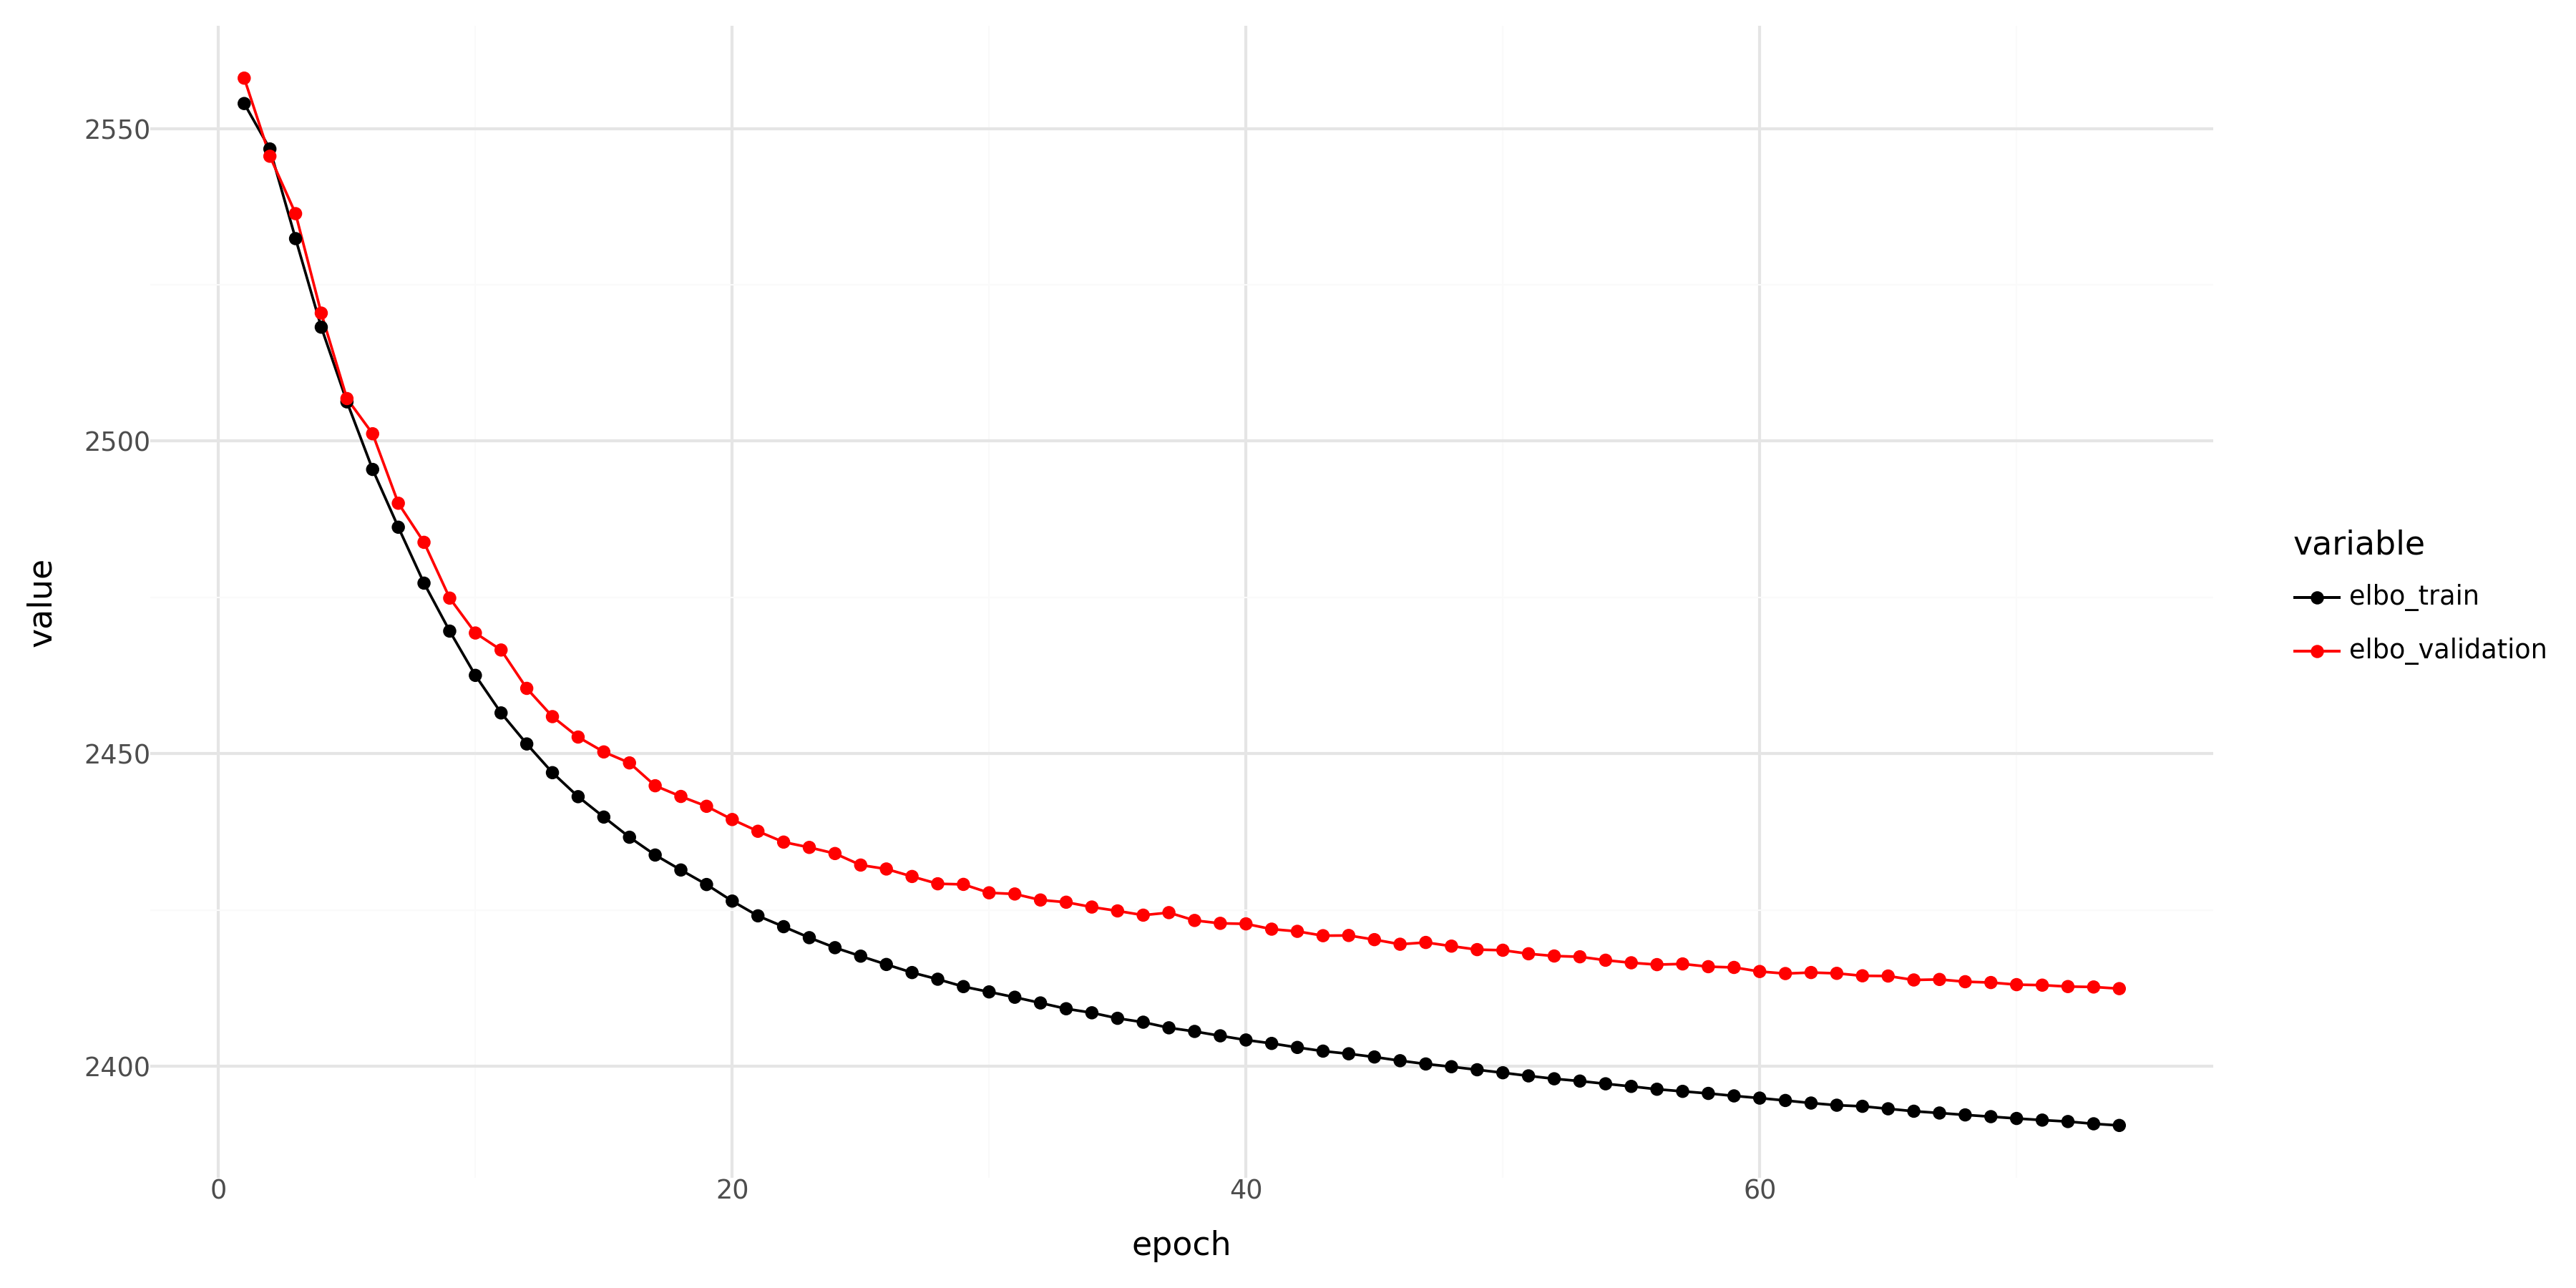

In [29]:
history_df = (
    scvi_model.history['elbo_train'].astype(float)
    .join(scvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

### Label transfer with `scANVI` 

In [30]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [31]:
scanvi_model.train(75, 
                 check_val_every_n_epoch = 1, 
                 enable_progress_bar = True, 
                 accelerator = 'gpu',
                 devices= [0])

INFO     Training for 75 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 75/75: 100%|██████████| 75/75 [09:38<00:00,  6.29s/it, v_num=1, train_loss_step=2.45e+3, train_loss_epoch=2.37e+3]

`Trainer.fit` stopped: `max_epochs=75` reached.


Epoch 75/75: 100%|██████████| 75/75 [09:38<00:00,  7.72s/it, v_num=1, train_loss_step=2.45e+3, train_loss_epoch=2.37e+3]


### Evaluate model performance a la Svensson

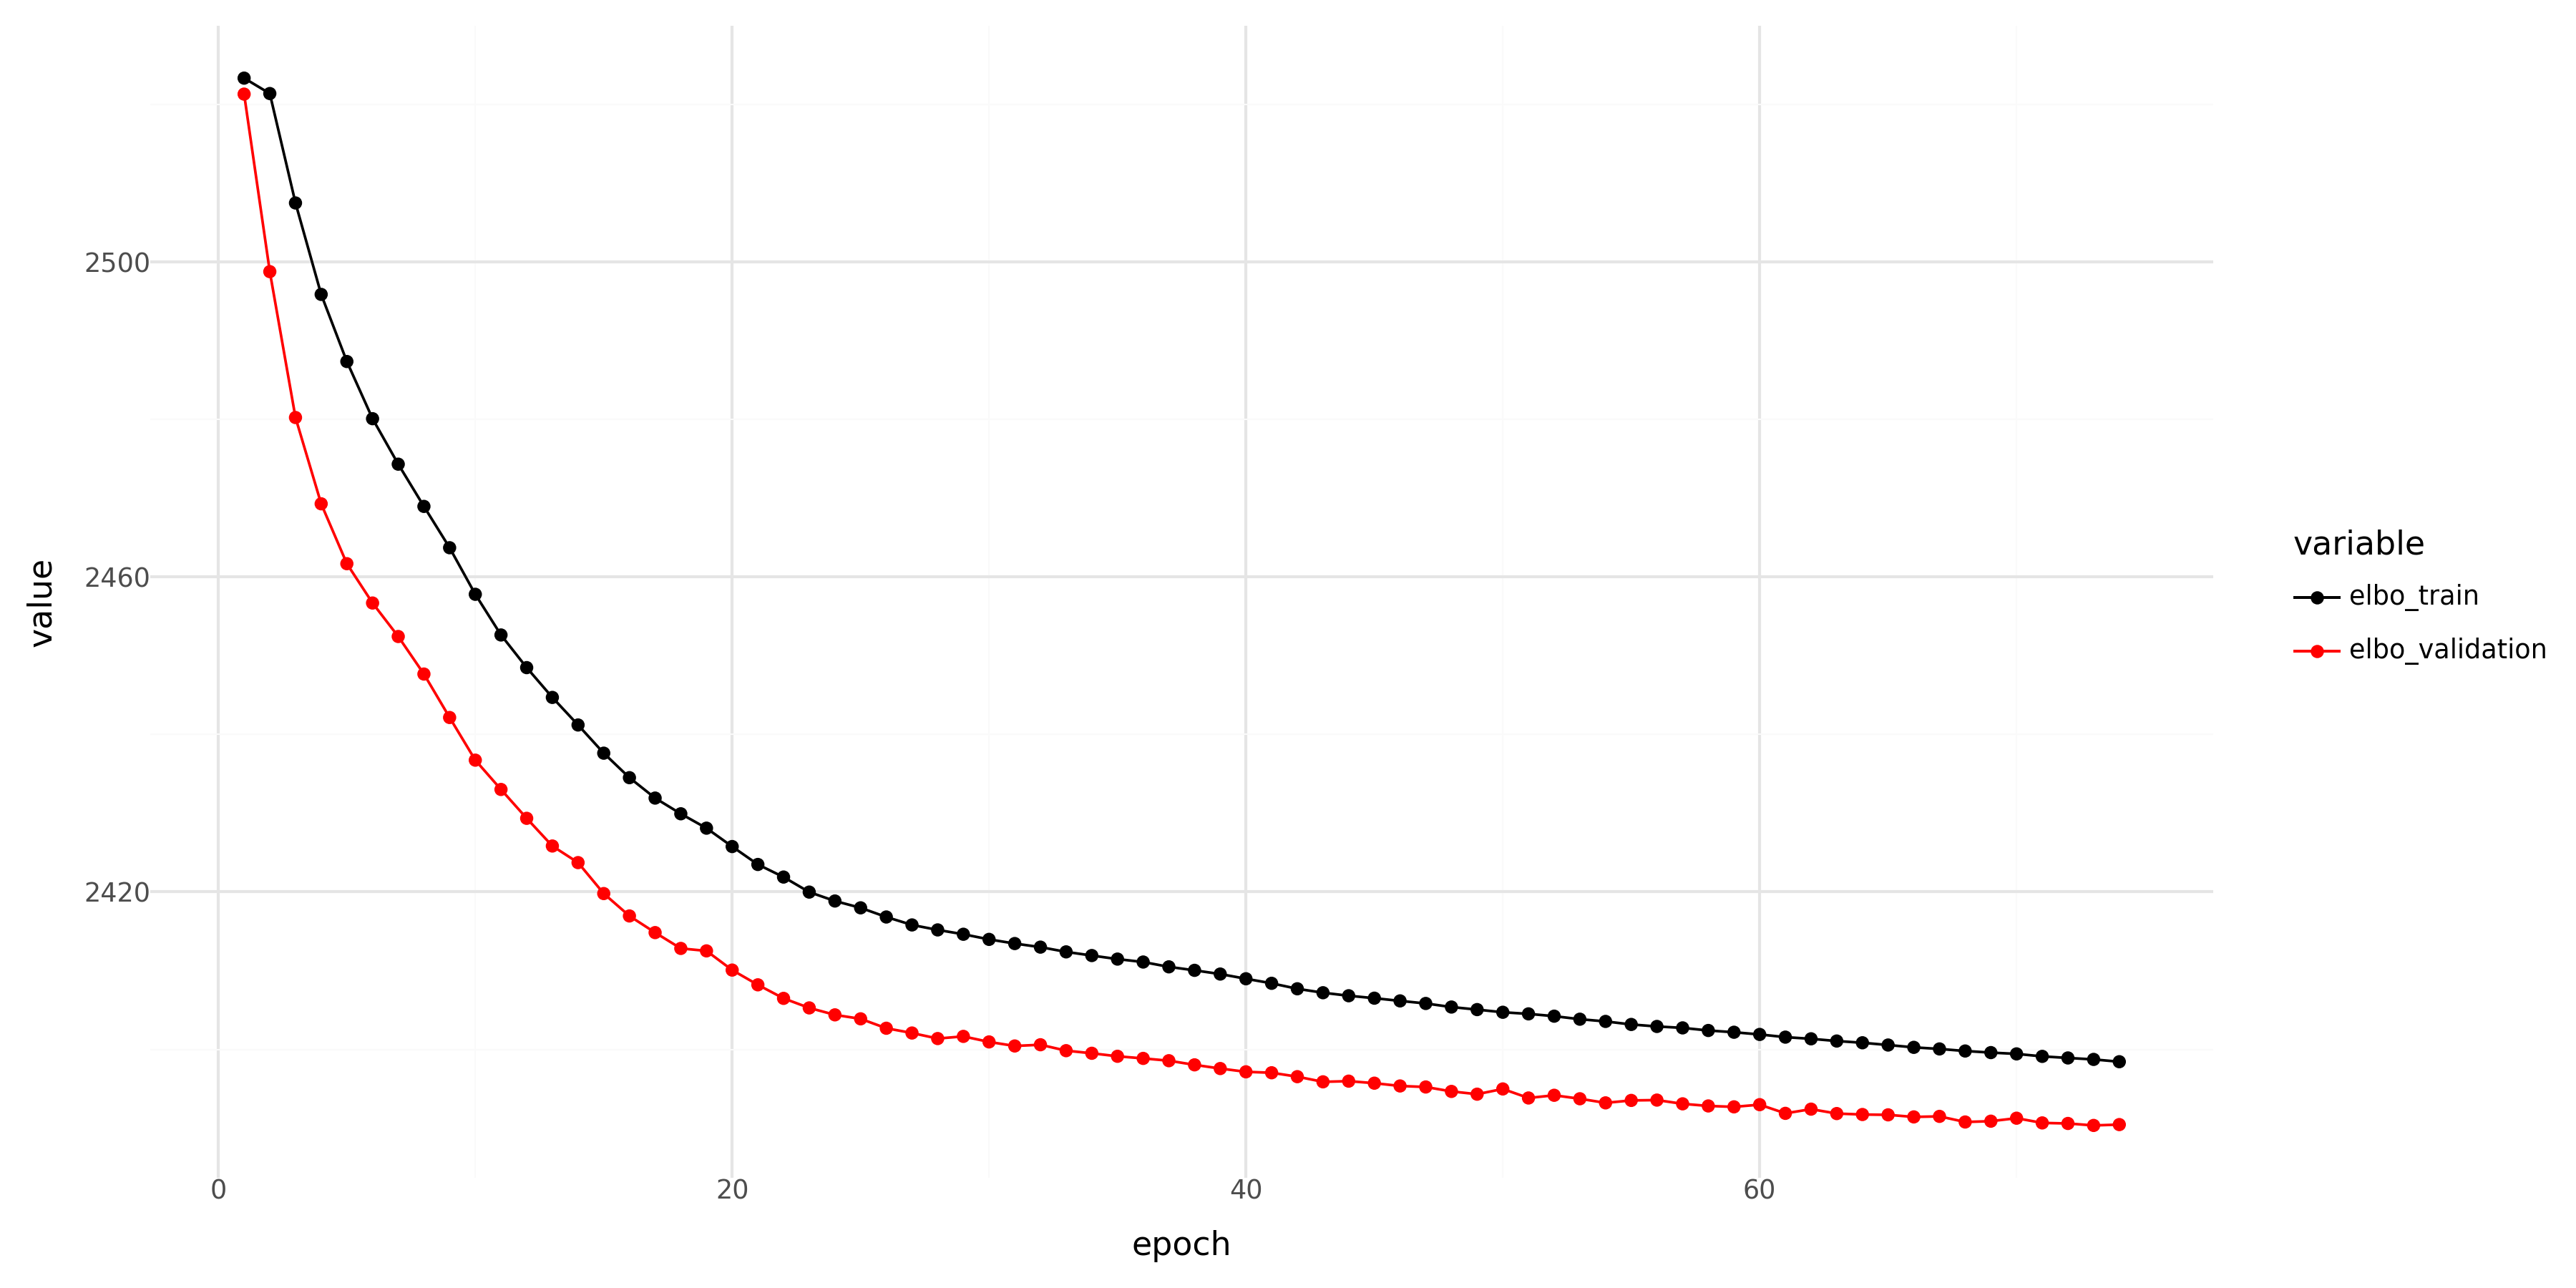

In [32]:
history_df = (
    scanvi_model.history['elbo_train'].astype(float)
    .join(scanvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

In [33]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

- Extract latent representation

In [34]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

- Visualise corrected dataset

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:32)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:33)
the obs value 'sample' has more than 103 categories. Uniform 'grey' color will be used for all categories.


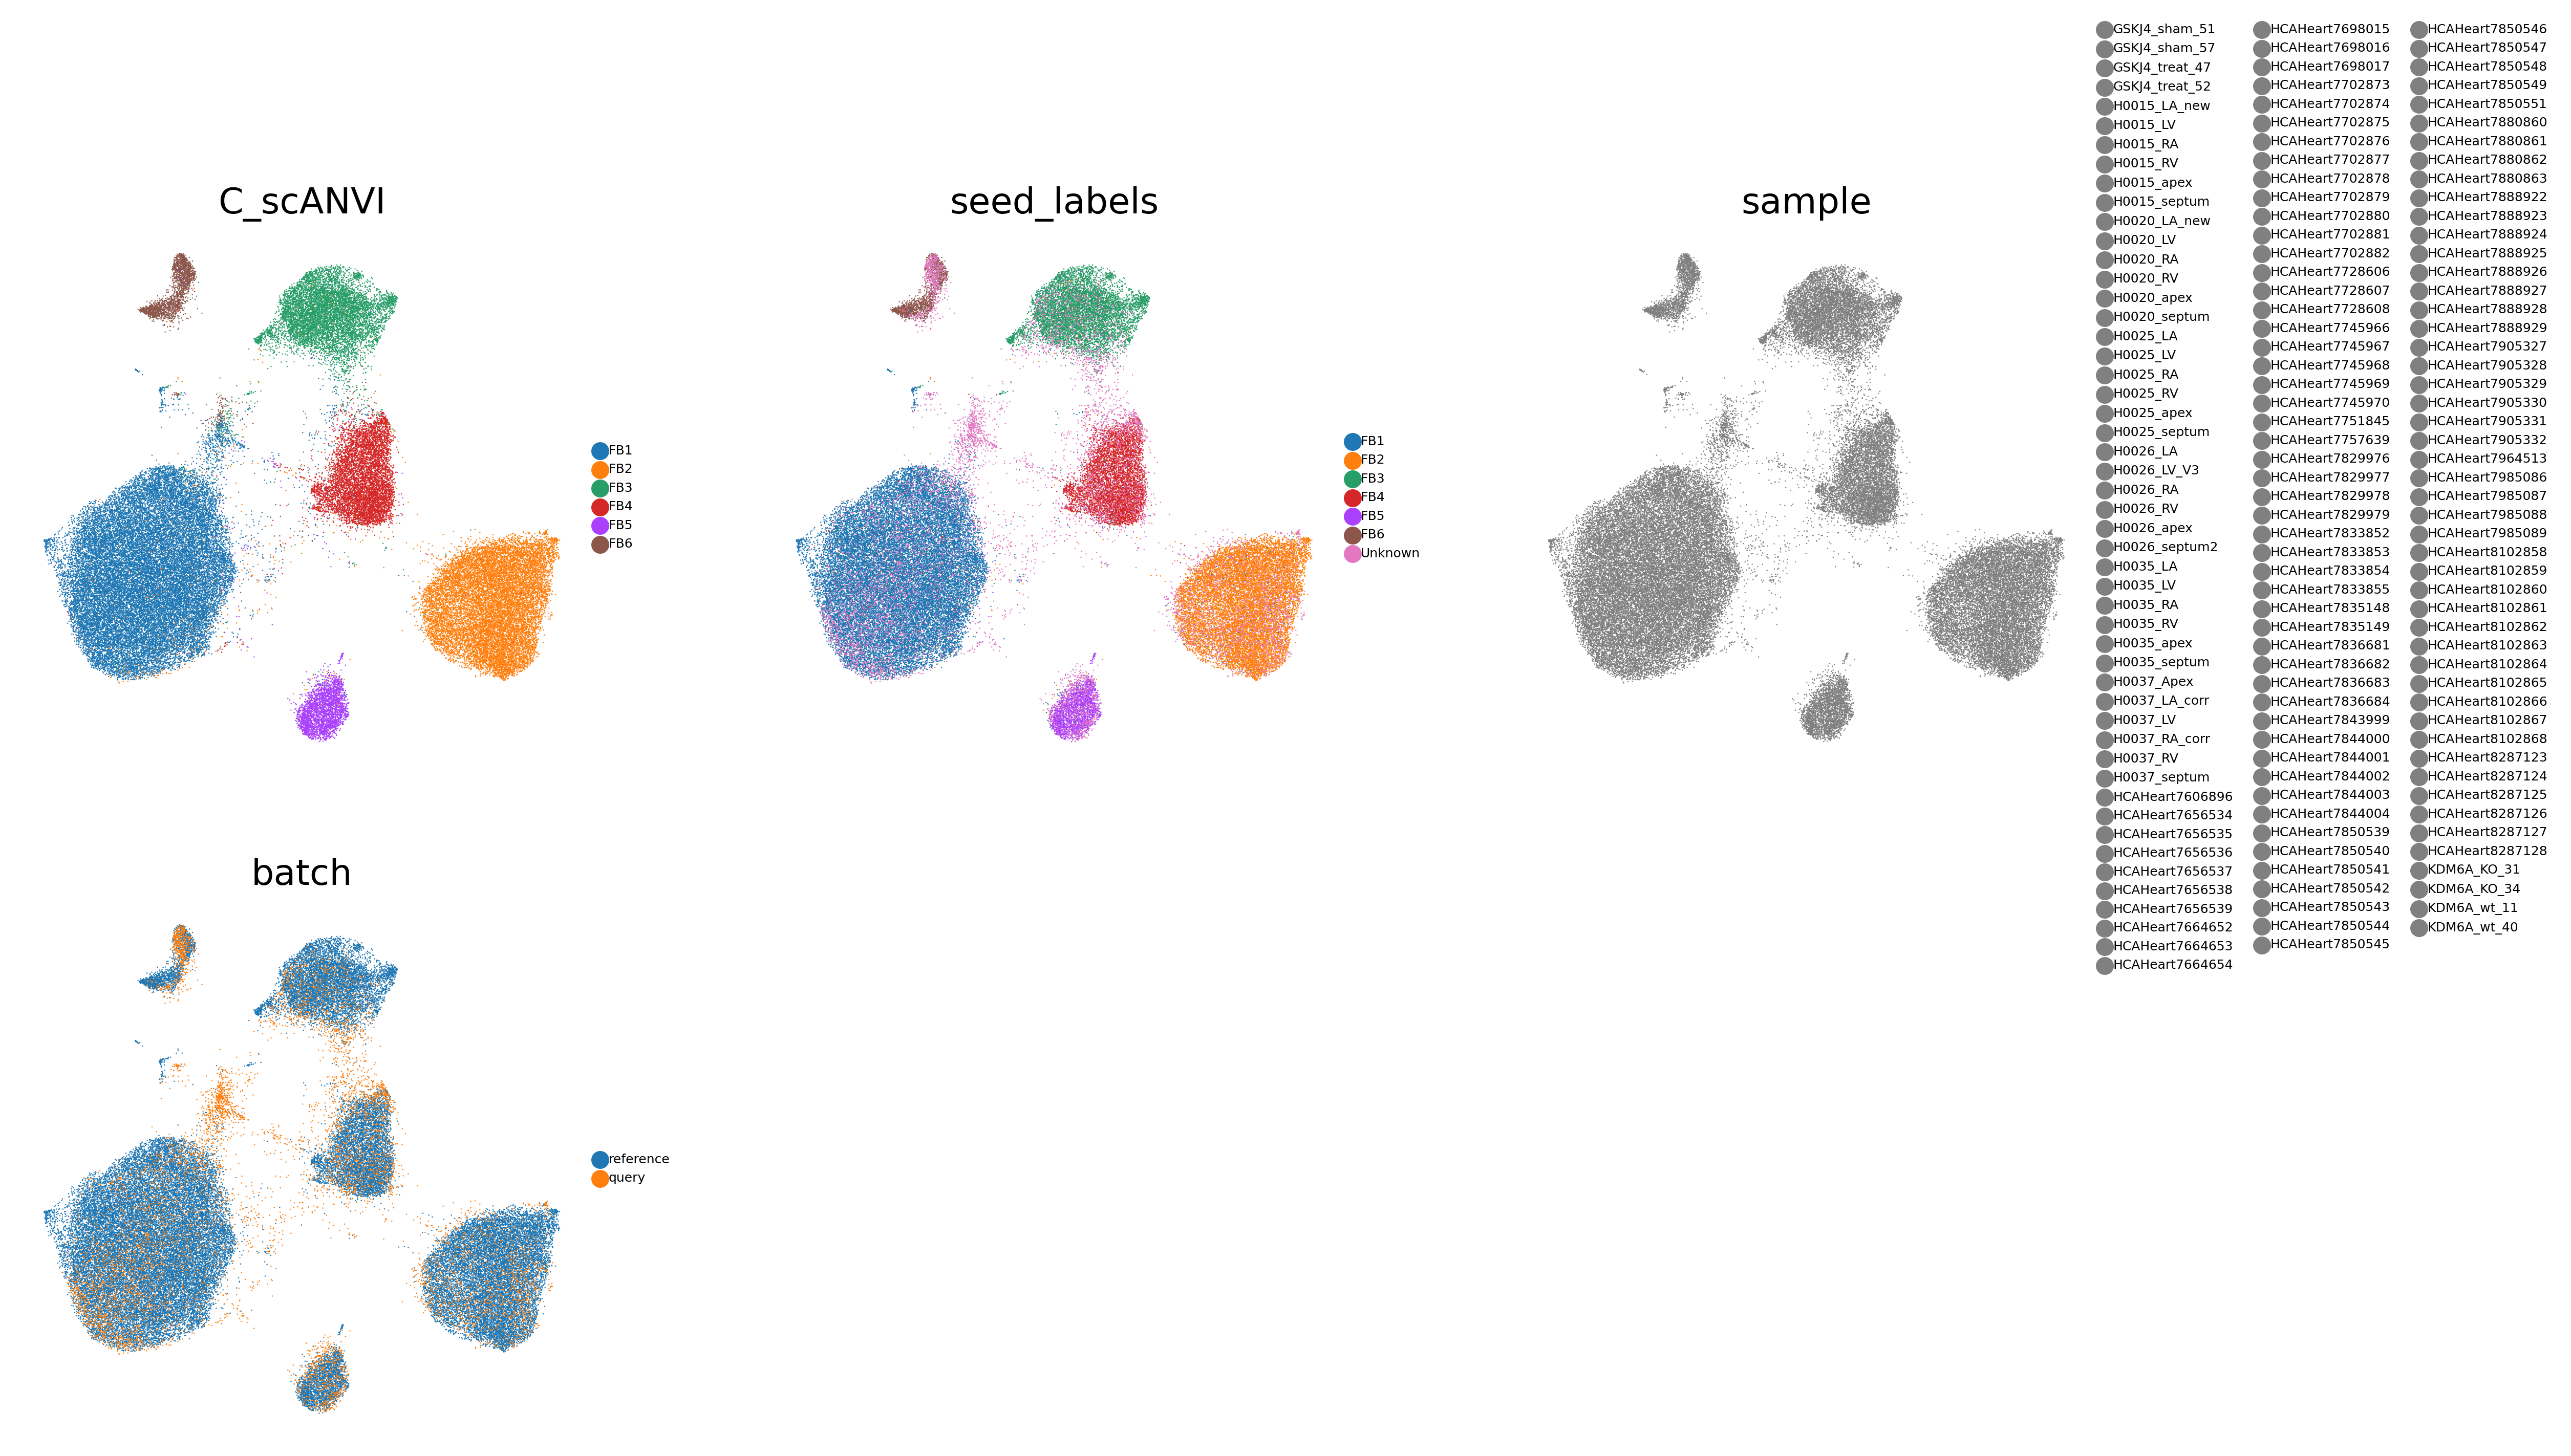

In [35]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.3, spread = 4, random_state = 1712)
sc.pl.umap(adata, frameon = False, color = ['C_scANVI', 'seed_labels', 'sample', 'batch'], size = 1, legend_fontsize = 5, ncols = 3)

### Evaluate integration with `scIB`

In [36]:
bm = Benchmarker(
    adata,
    batch_key="sample",
    label_key="C_scANVI",
    embedding_obsm_keys=["X_pca", "X_scVI", "X_scANVI"],
    n_jobs = -1,
)
bm.benchmark()

computing PCA
    with n_comps=50
    finished (0:00:17)


Embeddings: 100%|██████████| 3/3 [15:27<00:00, 309.10s/it]


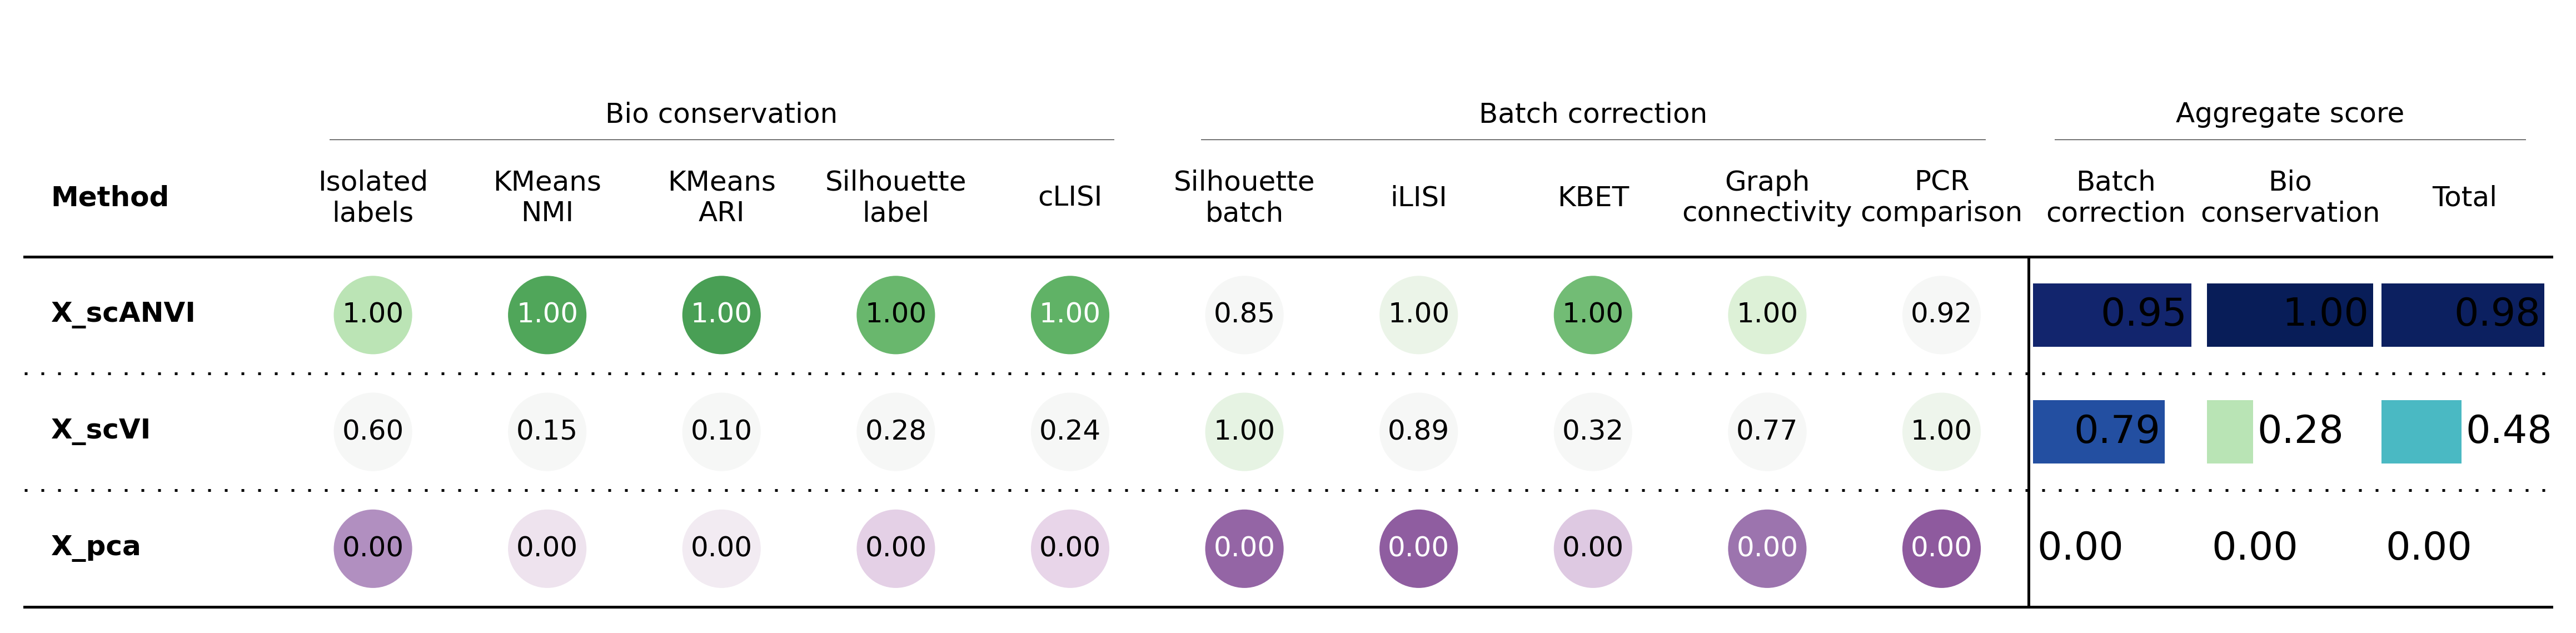

In [37]:
bm.plot_results_table()

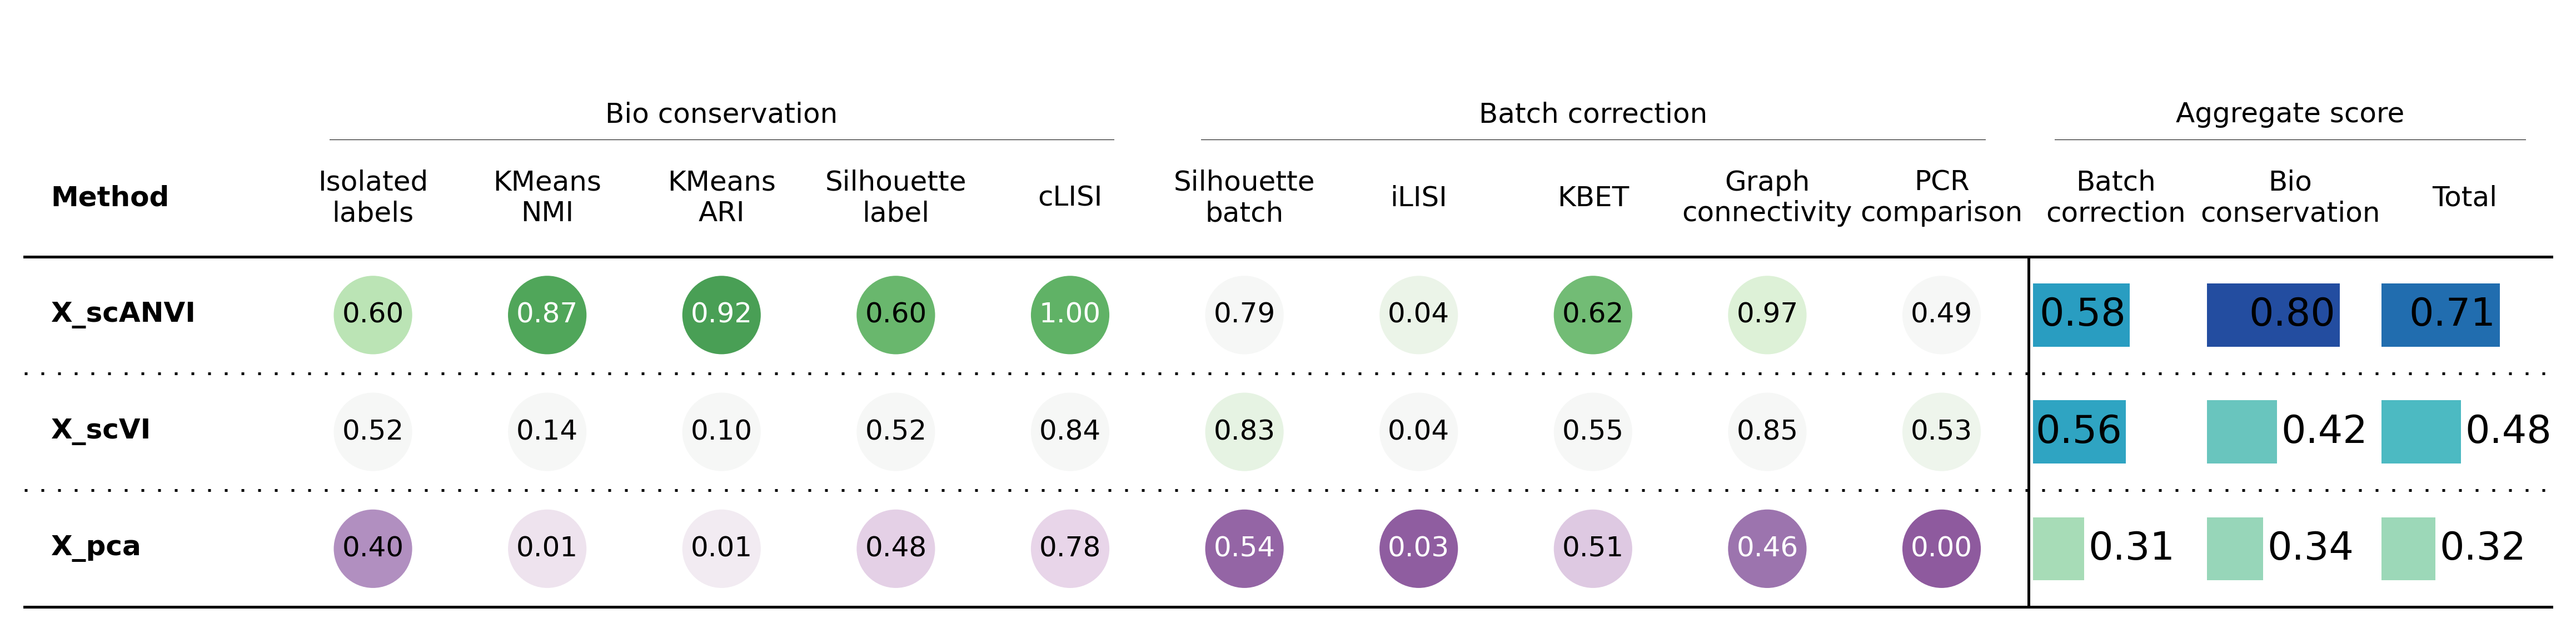

In [38]:
bm.plot_results_table(min_max_scale = False)

### Export annotated object

In [39]:
adata_export_merged = anndata.AnnData(X = adata_raw.X, var = adata_raw.var, obs = adata.obs)
adata_export_merged

AnnData object with n_obs × n_vars = 67197 × 14249
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'group', 'file', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-query', 'feature_types-query', 'genome-query', 'modality-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'gene_ids-Harvard-Nuclei-full-reference', 'feature_types-Harvard-Nuclei-full-reference', 'gene_ids-Sanger-Nuclei-full-reference', 'feature_types-Sanger-Nuclei-full-reference', 'gene_ids-Sanger-Cells-full-reference', 'feature_types-Sanger-Cells-full-reference', 'gene_ids-Sanger-CD45-full-

In [40]:
adata_export = adata_export_merged[adata_export_merged.obs['batch'].isin(['query'])]
adata_export

View of AnnData object with n_obs × n_vars = 8768 × 14249
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'group', 'file', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-query', 'feature_types-query', 'genome-query', 'modality-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'gene_ids-Harvard-Nuclei-full-reference', 'feature_types-Harvard-Nuclei-full-reference', 'gene_ids-Sanger-Nuclei-full-reference', 'feature_types-Sanger-Nuclei-full-reference', 'gene_ids-Sanger-Cells-full-reference', 'feature_types-Sanger-Cells-full-reference', 'gene_ids-Sanger-CD4

### Add new gene symbols

In [41]:
query_export = anndata.AnnData(X = query.X, var = query.var, obs = adata_export.obs)
query_export

AnnData object with n_obs × n_vars = 8768 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'group', 'file', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'genome', 'modality', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Revert gene symbols

In [42]:
query_export.var_names = [gene_name.capitalize() for gene_name in query_export.var_names]
query_export.var_names

Index(['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1', 'Sox17', 'Gm37587',
       'Gm37323', 'Mrpl15', 'Lypla1',
       ...
       'Gm16367', 'Ac163611.1', 'Ac163611.2', 'Ac140365.1', 'Ac124606.2',
       'Ac124606.1', 'Ac133095.2', 'Ac133095.1', 'Ac234645.1', 'Ac149090.1'],
      dtype='object', length=32285)

In [43]:
query_export.obs['C_scANVI'].value_counts()

C_scANVI
FB1    3228
FB2    1834
FB4    1236
FB3    1128
FB6     690
FB5     652
Name: count, dtype: int64

In [44]:
query_export

AnnData object with n_obs × n_vars = 8768 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'group', 'file', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'genome', 'modality', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [45]:
query_export.write('../../../data/Kdm6aKO_ALL_GEX-CB_scANVI-FB_ctl240311.raw.h5ad')